In [1]:
%%capture

###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['full_adata', 'DE_df', 'raw_adata'
            ]:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
usable_cores = multiprocessing.cpu_count()-1

# update subtypes
full_adata.obs['subtypes'] = ['follicular' if x in ['light_foll_mel', 'dark_foll_mel', 'cyc_foll_mel'] \
                         else y \
                         for x,y in zip(full_adata.obs.class_1, full_adata.obs.subtypes)]

# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['cutaneous','acral','foreskin','follicular']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
follicular_subtype_order = ['follicular','not_follicular']
dev_subtype_order = ['fet_acral','fet_cutaneous','fet_follicular','neo_foreskin','adt_acral','adt_cutaneous']

# create class_2 for site granularity
full_adata.obs['class_2'] = [x if x not in ['mel'] \
                             else f'{y}_mel'
                             for x,y in zip(full_adata.obs['class_1'], full_adata.obs['subtypes'])]

# create class_3 for site+dev_stage granularity
full_adata.obs['class_3'] = [x if not x.endswith('_mel') or x.startswith('cyc_') \
                             else f'{y}_{x}'
                             for x,y in zip(full_adata.obs['class_2'], full_adata.obs['dev_stage'])]

# update class_1 to pool by cell type
full_adata.obs['class_1'] = [x if not x.endswith('_mel') \
                             else 'mel' if not x.startswith('cyc_') \
                             else 'cyc_mel' \
                             for x in full_adata.obs['class_1']]
type_order_1 = ['mel',
                'cyc_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]
    
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )
DE_df = DE_df.dropna()

type_order_2 = ['cutaneous_mel',
                'acral_mel',
                'foreskin_mel',
                'dark_foll_mel',
                'light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]

type_order_3 = ['adt_cutaneous_mel',
                'adt_acral_mel',
                'neo_foreskin_mel',
                'fet_cutaneous_mel',
                'fet_acral_mel',
                'fet_dark_foll_mel',
                'fet_light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]


In [2]:
# # DE test
# print('computing...')
# gene_n = 100
# target_set = ['adt_acral_mel']
# ref_set = ['adt_cutaneous_mel']
# source_groupby = 'class_3'
# input_adata = full_adata

# input_adata = input_adata[[x in target_set+ref_set for x in input_adata.obs[source_groupby]]]
# input_adata.obs['DE_grouping'] = ['target' if x in target_set \
#                             else 'ref' \
#                             for x in input_adata.obs[source_groupby]]

# genelist_adt_acral = fast_DE(input_adata, clusterOI='target', groupby='DE_grouping', reference='ref', gene_n=gene_n)
# genelist_adt_cut = fast_DE(input_adata, clusterOI='ref', groupby='DE_grouping', reference='target', gene_n=gene_n)


In [3]:
# # DE test
# print('computing...')
# gene_n = 100
# target_set = ['fet_acral_mel']
# ref_set = ['fet_cutaneous_mel']
# source_groupby = 'class_3'
# input_adata = full_adata

# input_adata = input_adata[[x in target_set+ref_set for x in input_adata.obs[source_groupby]]]
# input_adata.obs['DE_grouping'] = ['target' if x in target_set \
#                             else 'ref' \
#                             for x in input_adata.obs[source_groupby]]

# genelist_fet_acral = fast_DE(input_adata, clusterOI='target', groupby='DE_grouping', reference='ref', gene_n=gene_n)
# genelist_fet_cut = fast_DE(input_adata, clusterOI='ref', groupby='DE_grouping', reference='target', gene_n=gene_n)


In [4]:
# df = pd.DataFrame({'adt_acral>adt_cut':genelist_adt_acral,
#                    'adt_cut>adt_acral':genelist_adt_cut,
#                    'fet_acral>fet_cut':genelist_fet_acral,
#                    'fet_cut>fet_acral':genelist_fet_cut,
#                   })
# df.to_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/DE_forRob.csv')

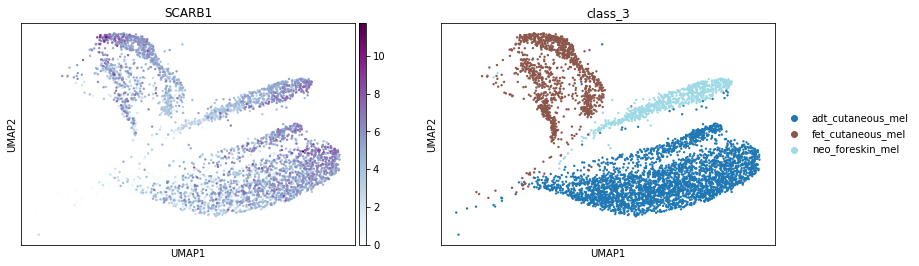

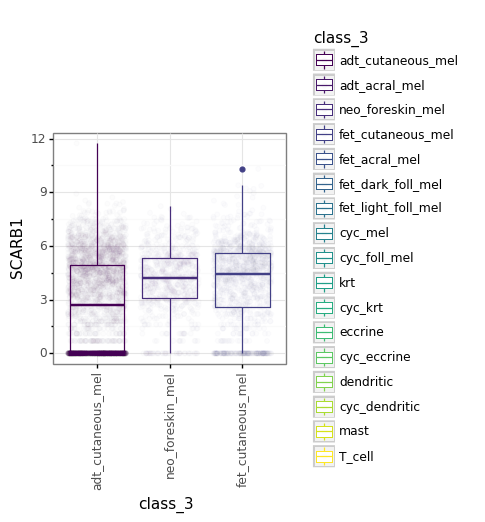

<ggplot: (-9223363291408466972)>
querying 1-1...done.
Finished.
0:  SCARB1 
 The protein encoded by this gene is a plasma membrane receptor for high density lipoprotein cholesterol (HDL). The encoded protein mediates cholesterol transfer to and from HDL. In addition, this protein is a receptor for hepatitis C virus glycoprotein E2. Several transcript variants encoding different isoforms have been found for this gene.[provided by RefSeq, Jan 2019].


In [25]:
# look up gene
gene = 'SCARB1'
groupby = 'class_3'
#input_adata = full_adata

### fsk analysis ###
type_order = ['fet_cutaneous_mel','neo_foreskin_mel', 'adt_cutaneous_mel'] 
input_adata = full_adata[[x in type_order for x in full_adata.obs[groupby]]]
###

sc.pl.umap(input_adata, color = [gene,groupby], cmap='BuPu', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata[[not x.startswith('cyc') \
                                              for x in input_adata.obs[groupby]]],
                            gene,
                            groupby
                           )

plot_df = plot_df.reset_index()
if groupby == 'class_3':
    plot_df[groupby] = (plot_df[groupby]
                       .astype(str)
                        .astype(CategoricalDtype(type_order_3,ordered=True))
                       )
plot_df = plot_df.dropna()

plotnine.options.figure_size = (3,3)
plot = (ggplot(plot_df)
          + theme_bw()
          + theme(axis_text_x = element_text(angle = 90))
          + geom_boxplot(aes(groupby, gene, color = groupby))
          + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.01)
         )
print(plot)

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


In [36]:
# run this to download plot

fn = 'lookup_boxplot_S100b.pdf'
local_dest = f'/home/ubuntu/data/DL20181011_melanocyte_test_data/test_prints/{fn}'
ggsave(plot, local_dest)
s3_dest = 'daniel.le-work/MEL_project/plot_prints/test_prints/'
! aws s3 cp {local_dest} s3://{s3_dest}
! rm local_dest
print('\n', 'download here:', f'https://s3-us-west-2.amazonaws.com/{s3_dest}{fn}')

upload: ../../data/DL20181011_melanocyte_test_data/test_prints/lookup_boxplot_S100b.pdf to s3://daniel.le-work/MEL_project/plot_prints/test_prints/lookup_boxplot_S100b.pdf
rm: cannot remove 'local_dest': No such file or directory

 download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/test_prints/lookup_boxplot_S100b.pdf


In [37]:
print('computing...')
## NTRK2/HPGD look-up
input_adata = full_adata
print(set(input_adata.obs.class_2))
groupby_1 = 'class_2'
groupby_2 = 'patient'

cat, df = prepare_dataframe(input_adata,
                           ['NTRK2','ERBB3'],
                           'cell')
df[groupby_1] = input_adata.obs[groupby_1].values
df[groupby_2] = input_adata.obs[groupby_2].values

# filter on acral vs cutaneous
df = df[[x in ['acral_mel','cutaneous_mel',] for x in df[groupby_1]]]
df.groupby([groupby_1,groupby_2]).mean().dropna().reset_index()

computing...
{'cutaneous_mel', 'dendritic', 'cyc_eccrine', 'light_foll_mel', 'cyc_foll_mel', 'foreskin_mel', 'krt', 'T_cell', 'acral_mel', 'dark_foll_mel', 'mast', 'cyc_dendritic', 'eccrine', 'cyc_mel', 'cyc_krt'}


,class_2,patient,NTRK2,ERBB3
0,acral_mel,10WK03,1.805200,3.483235
1,acral_mel,12WK05,3.936502,4.406474
2,acral_mel,12WKM01,2.381269,3.665097
3,acral_mel,16WKM04,2.301708,3.011860
4,acral_mel,18WKM06,2.213098,3.867733
5,acral_mel,A1038LM,2.166930,2.286014
6,acral_mel,A1046M,2.352038,3.252002
7,cutaneous_mel,9.5WK02,0.842467,3.959283
8,cutaneous_mel,10WK03,0.117757,2.801710
9,cutaneous_mel,12WK05,1.144042,4.256868


In [38]:
input_adata

AnnData object with n_obs × n_vars = 10119 × 24572 
    obs: 'age', 'age_bin', 'plate', 'general_location', 'anatomical_location', 'race', 'sex', 'color', 'patient', 'n_genes', 'n_counts', 'cell', 'cycling_score', 'cycling_cell', 'bsc', 'fsc', 'gate_label', 'contam_1', 'contam_2', 'louvain', 'named_cluster', 'true_year', 'dev_stage', 'subtypes', 'acral_subtype', 'dev_subtype', 'class_1', 'class_2', 'class_3'
    var: 'ribo', 'ercc', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'named_cluster_colors', 'class_1_colors', 'rank_genes_groups', 'class_3_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

computing...


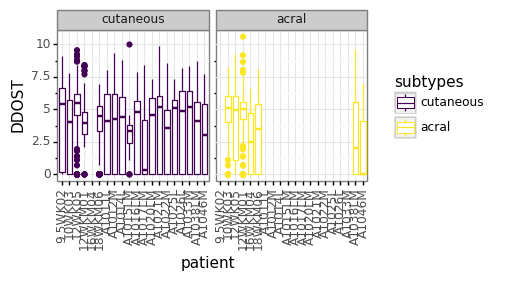

<ggplot: (8745442343695)>


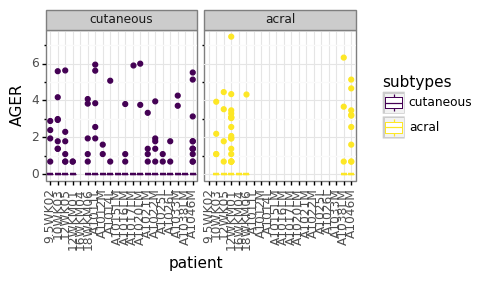

<ggplot: (8745442588203)>


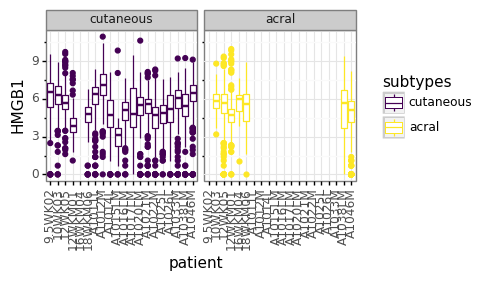

<ggplot: (8745441530183)>


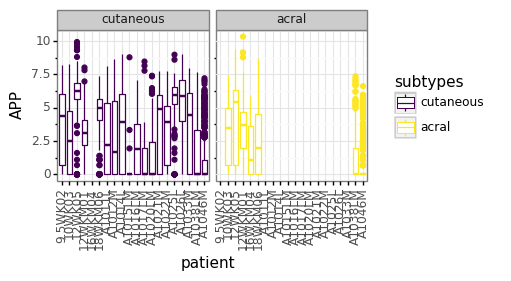

<ggplot: (-9223363291412954087)>


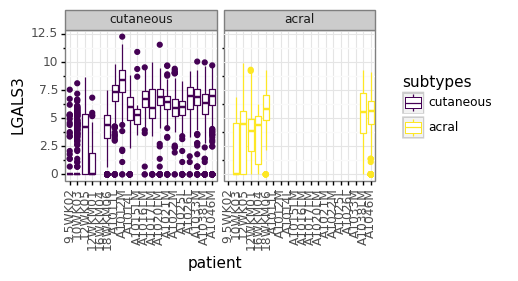

<ggplot: (8745442867278)>


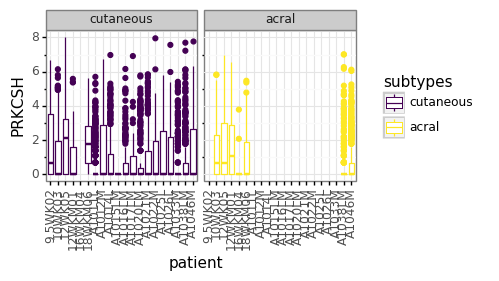

<ggplot: (-9223363291412987616)>


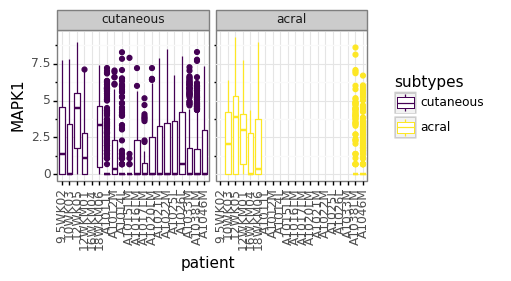

<ggplot: (8745444900093)>


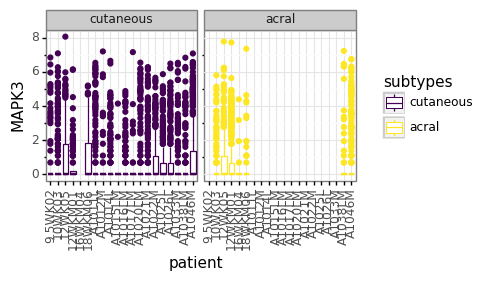

<ggplot: (-9223363291412421695)>


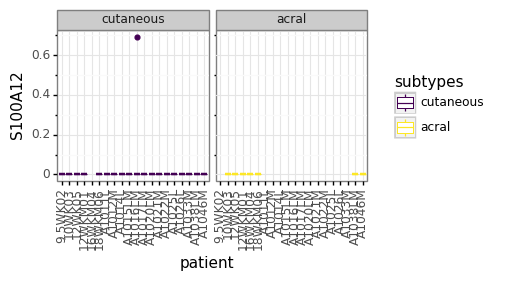

<ggplot: (-9223363291412178004)>


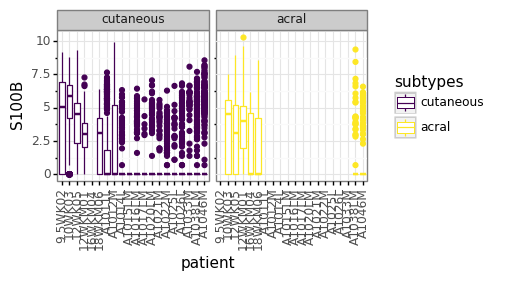

<ggplot: (8745441889270)>


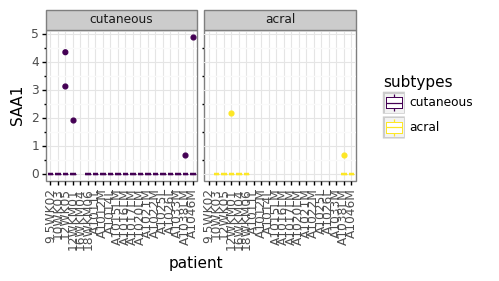

<ggplot: (8745447286718)>


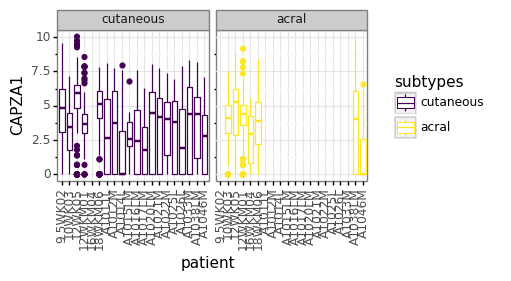

<ggplot: (-9223363291409749458)>


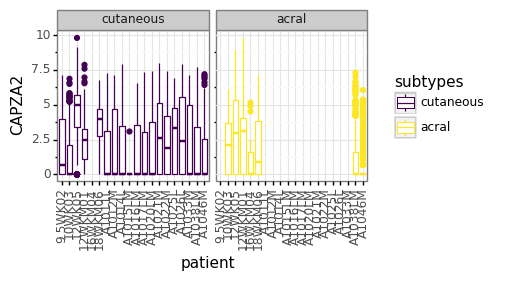

<ggplot: (8745442817849)>


In [40]:
print('computing...')


# gene correlation to bsc
genes = [


'DDOST',
'AGER',
'HMGB1',
'APP',
'LGALS3',
'PRKCSH',
'MAPK1',
'MAPK3',
'S100A12',
'S100B',
'SAA1',
'CAPZA1',
'CAPZA2'

]

input_adata = full_adata[full_adata.obs.class_1 == 'mel']
plot_df = pd.DataFrame(input_adata.obs.groupby(['patient','subtypes'])['bsc'].mean()).reset_index()
plot_df = plot_df[[x in ['acral','cutaneous'] for x in plot_df.subtypes]]

# determine samples with acral and cutaneous
filter_df = pd.DataFrame(plot_df['patient'].value_counts())
filter_df = filter_df[filter_df['patient'] > 1]
filter_list = filter_df.index.tolist()

input_adata = full_adata[full_adata.obs.class_1 == 'mel']
input_adata = input_adata[[x in filter_list for x in input_adata.obs.patient]]

for goi in genes:
    cat, df = prepare_dataframe(input_adata,
                                goi,
                                'patient'
                               )
    df = df.reset_index()
    df['subtypes'] = input_adata.obs.subtypes.tolist() 
    df['subtypes'] = (df['subtypes']
                      .astype(str)
                      .astype(CategoricalDtype(['cutaneous','acral'], ordered = True))
                     )
    df = df.dropna()
    plotnine.options.figure_size = (4,4)
    plot = (ggplot(df)
            + theme_bw()
            + theme(axis_text_x = element_text(angle = 90),
                    aspect_ratio = 1)
            + geom_boxplot(aes('patient',goi,color='subtypes'))
            + facet_wrap('~subtypes', ncol = 6)
           )
    print(plot)

In [39]:
# see available groups based on grouping feature
grouping_features = ['class_1', 'class_2', 'class_3'] 
for grouping_feature in grouping_features:
    print(grouping_feature)
    display(set(full_adata.obs[grouping_feature]))

class_1


{'T_cell',
 'cyc_dendritic',
 'cyc_eccrine',
 'cyc_krt',
 'cyc_mel',
 'dendritic',
 'eccrine',
 'krt',
 'mast',
 'mel'}

class_2


{'T_cell',
 'acral_mel',
 'cutaneous_mel',
 'cyc_dendritic',
 'cyc_eccrine',
 'cyc_foll_mel',
 'cyc_krt',
 'cyc_mel',
 'dark_foll_mel',
 'dendritic',
 'eccrine',
 'foreskin_mel',
 'krt',
 'light_foll_mel',
 'mast'}

class_3


{'T_cell',
 'adt_acral_mel',
 'adt_cutaneous_mel',
 'cyc_dendritic',
 'cyc_eccrine',
 'cyc_foll_mel',
 'cyc_krt',
 'cyc_mel',
 'dendritic',
 'eccrine',
 'fet_acral_mel',
 'fet_cutaneous_mel',
 'fet_dark_foll_mel',
 'fet_light_foll_mel',
 'krt',
 'mast',
 'neo_foreskin_mel'}

In [13]:
input_adata = full_adata
clusterOI = 'fet_acral_mel' # select group of interest
groupby = 'class_3' # select grouping feature
reference = 'fet_cutaneous_mel' # select group for comparison (ie clusterOI > reference) or "rest" to compare to sum of all other features
n_genes = 20# number of top DE genes to print
sc.tl.rank_genes_groups(input_adata, 
                        groupby=groupby, 
                        groups=[clusterOI], 
                        method='wilcoxon',
                        reference=reference,
                        n_genes = n_genes)
genes = [x[0] for x in input_adata.uns['rank_genes_groups']['names']]
pvals = [x[0] for x in input_adata.uns['rank_genes_groups']['pvals']]

# pvals are uncorrected
display(pd.DataFrame({'gene':genes, 'pvals':pvals}))


,gene,pvals
0,ID3,1.233505e-100
1,ID2,3.856501e-97
2,IGDCC4,1.965023e-79
3,NTRK2,6.402643e-74
4,RAB3B,1.400937e-64
5,UACA,1.845040e-63
6,EIF5AL1,9.407859e-62
7,RUNX3,1.783699e-52
8,PHACTR3,3.896722e-50
9,PDLIM3,1.193345e-46


# acral vs cutaneous heatmap

computing...


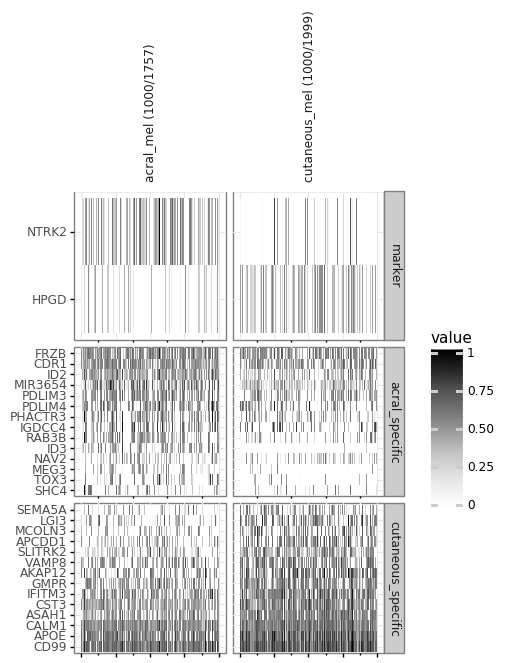

<ggplot: (-9223363265814921535)>


In [4]:
print('computing...')
gene_n = 15
target_set = ['acral_mel']
ref_set = ['cutaneous_mel']
source_groupby = 'class_2'
filter_list = ['A1046M', 'A1038LM', '10WK03', '12WK05', '12WKM01', '18WKM06']
input_adata = full_adata[[x in filter_list for x in full_adata.obs.patient]]

input_adata = input_adata[[x in target_set+ref_set for x in input_adata.obs[source_groupby]]]
input_adata.obs['DE_grouping'] = ['target' if x in target_set \
                            else 'ref' \
                            for x in input_adata.obs[source_groupby]]

genelist_acr = fast_DE(input_adata, clusterOI='target', groupby='DE_grouping', reference='ref', n_genes=100)
genelist_cut = fast_DE(input_adata, clusterOI='ref', groupby='DE_grouping', reference='target', n_genes=100)
gene_order = genelist_acr[:gene_n] + genelist_cut[:gene_n]

input_adata = full_adata[[x in filter_list for x in full_adata.obs.patient]]
n_cells = 1000
groupby = 'class_2'

# extract cell types and genes order
type_order = ['acral_mel',
              'cutaneous_mel',
             ]

cat, exp_df = prepare_dataframe(input_adata,
                 var_names = gene_order,
                 groupby = 'cell')

exp_df = exp_df.apply(lambda x: min_max_scaler(x.values))
exp_df[groupby] = input_adata.obs[groupby].tolist()

compiled_rows = pd.DataFrame()
type_order_revised = []
for x in type_order:
    df_slice = exp_df[exp_df[groupby] == x]
    df_nrow = len(df_slice)
    if df_nrow >= n_cells:
        df_sample = df_slice.sample(n_cells, random_state = 0)
        num_cell = n_cells
    else:
        df_sample = df_slice
        num_cell = df_nrow
    idx_list = [x for x in range(len(df_sample))]
    random.shuffle(idx_list)
    df_sample['idx'] = idx_list
    df_sample[groupby] = f'{x} ({num_cell}/{df_nrow})'
    type_order_revised = type_order_revised + [f'{x} ({num_cell}/{df_nrow})']
    compiled_rows = compiled_rows.append(df_sample)
    
compiled_rows_melt = pd.melt(compiled_rows, id_vars=[groupby,'idx'])
compiled_rows_melt[groupby] = (compiled_rows_melt[groupby]
                                 .astype(str)
                                 .astype(CategoricalDtype(type_order_revised,
                                                          ordered=True
                                                         )
                                        )
                                )

# order genes
compiled_rows_melt['group'] = ['acral_specific' if (x in genelist_acr and x not in ['NTRK2','HPGD',]) \
                               else 'cutaneous_specific' if x not in ['NTRK2','HPGD',] \
                               else 'marker' if x in ['NTRK2','HPGD',] \
                               else 'NA' for x in compiled_rows_melt['variable']]
acr_list = pd.DataFrame(compiled_rows_melt[[x == 'acral_specific' and \
                                            (y.startswith('acral_mel') or y.startswith('acral_mel')) \
                                for x,y in zip(compiled_rows_melt.group,
                                                        compiled_rows_melt[groupby]
                                                       )]]
             .groupby('variable')['value']
             .apply(lambda x: np.mean(x))
             .dropna()
             .reset_index()
             .sort_values('value')
            )['variable'].tolist()
cut_list = pd.DataFrame(compiled_rows_melt[[x == 'cutaneous_specific' and \
                                            (y.startswith('cutaneous_mel') or y.startswith('cutaneous_mel')) \
                                for x,y in zip(compiled_rows_melt.group,
                                                        compiled_rows_melt[groupby]
                                                       )]]
             .groupby('variable')['value']
             .apply(lambda x: np.mean(x))
             .dropna()
             .reset_index()
             .sort_values('value')
            )['variable'].tolist()

compiled_rows_melt['variable'] = (compiled_rows_melt['variable']
                                 .astype(str)
                                 .astype(CategoricalDtype(['HPGD','NTRK2',]+acr_list+cut_list[::-1],
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt['group'] = (compiled_rows_melt['group']
                                 .astype(str)
                                 .astype(CategoricalDtype(['marker','acral_specific','cutaneous_specific'],
                                                          ordered=True
                                                         )
                                        )
                                )
compiled_rows_melt = compiled_rows_melt.dropna()


plotnine.options.figure_size = (4,6)
plot = (ggplot(compiled_rows_melt)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              strip_text_x = element_text(angle = 90, vjust = 0),
              strip_background_x = element_rect(fill = 'white', color = 'white') )
      + geom_tile(aes('idx','variable',fill='value'))
      + facet_grid(f'group~{groupby}', 
                   space = 'free',
                   scales = 'free'
                  )
      + scale_fill_cmap('Greys')#copper
      + labs(x = '', y = '')
       )

print(plot)


In [29]:
# run this to download plot

fn = 'acr_v_cut_heatmap.pdf'
local_dest = f'/home/ubuntu/data/DL20181011_melanocyte_test_data/test_prints/{fn}'
ggsave(plot, local_dest)
s3_dest = 'daniel.le-work/MEL_project/plot_prints/test_prints/'
! aws s3 cp {local_dest} s3://{s3_dest}
! rm local_dest
print('\n', 'download here:', f'https://s3-us-west-2.amazonaws.com/{s3_dest}{fn}')


upload: ../../data/DL20181011_melanocyte_test_data/test_prints/acr_v_cut_heatmap.pdf to s3://daniel.le-work/MEL_project/plot_prints/test_prints/acr_v_cut_heatmap.pdf
rm: cannot remove 'local_dest': No such file or directory

 download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/test_prints/acr_v_cut_heatmap.pdf


# Mels only recluster

In [19]:
if not 'run_recluster' in globals():

    n_pcs = 75
    coi = full_adata[[x in ['cutaneous_mel',
                    'acral_mel',
                    'foreskin_mel',
                    'dark_foll_mel',
                    'light_foll_mel',] for x in full_adata.obs.class_2]].obs.index.tolist()
    raw_adata.obs['recluster'] = [x in coi for x in raw_adata.obs.index]
    adata_subset2 = raw_adata[raw_adata.obs['recluster'] == True]
    adata_subset2 = sc.pp.log1p(adata_subset2, copy=True) # new
    sc.pp.highly_variable_genes(adata_subset2,min_mean=0.1,max_mean=10,min_disp=0.5) # new
    sc.pp.scale(adata_subset2) # new
    sc.tl.pca(adata_subset2, use_highly_variable = True, n_comps=n_pcs) # new
    sc.pp.neighbors(adata_subset2, n_pcs=n_pcs, n_neighbors=100) # new
    sc.tl.umap(adata_subset2, min_dist = 0.5)
    sc.tl.louvain(adata_subset2, resolution = 0.25)

    # add feature labels
    for input_adata in [adata_subset2]:
        input_adata.obs['true_year'] = [float(x.split('WK')[0])/52 if len(x.split('WK')[0]) <= 3 else np.nan for x in input_adata.obs.patient]
        input_adata.obs['true_year'] = [y+(9/12) if np.isnan(x) else x for x,y in zip(input_adata.obs['true_year'], input_adata.obs['age']) ]

        input_adata.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in input_adata.obs.age]
        input_adata.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in input_adata.obs.general_location]
        foll_idx = full_adata[[x in ['light_foll_mel','dark_foll_mel'] for x in full_adata.obs.class_2]].obs.index.tolist()
        input_adata.obs['subtypes'] = ['follicular' if x in foll_idx \
                                       else y for x,y in zip(input_adata.obs.index, input_adata.obs['subtypes'])]
        input_adata.obs['acral_subtype'] = [x if x == 'acral' else 'not_acral' for x in input_adata.obs['subtypes']]
        input_adata.obs['foreskin_subtype'] = [x if x == 'foreskin' else 'not_foreskin' for x in input_adata.obs['subtypes']]
        input_adata.obs['follicular_subtype'] = [x if x == 'follicular' else 'not_follicular' for x in input_adata.obs['subtypes']]

        input_adata.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(input_adata.obs.dev_stage, input_adata.obs.subtypes)]


        for i in ['dev_stage', 'subtypes', 'acral_subtype' ,'foreskin_subtype','follicular_subtype','dev_subtype']:
            input_adata.obs[i] =  (input_adata
                                     .obs[i]
                                     .astype(str)
                                   .astype(CategoricalDtype(eval(f'{i}_order'), ordered = True))
                                  )
            

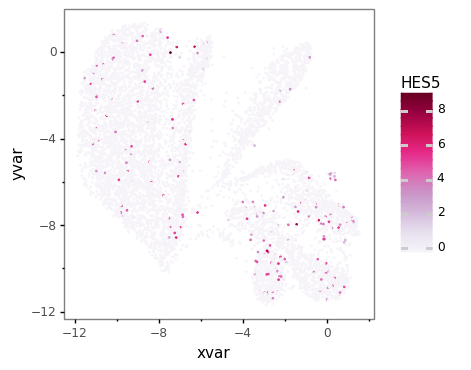

<ggplot: (-9223363299404027041)>


In [26]:
# plot
GOI = 'HES5'

input_adata = adata_subset2
cat, df = prepare_dataframe(input_adata,
                            GOI,
                            'cell'
                           )
umap_df = pd.DataFrame(input_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df[GOI] = df[GOI].values

plotnine.options.figure_size = (4,4)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color=GOI), size = 0.1)
        + scale_color_cmap('PuRd') #magma
       )
print(plot)

In [57]:
# run this to download plot

fn = 'mel_only_lookup_umap.pdf'
local_dest = f'/home/ubuntu/data/DL20181011_melanocyte_test_data/test_prints/{fn}'
ggsave(plot, local_dest)
s3_dest = 'daniel.le-work/MEL_project/plot_prints/test_prints/'
! aws s3 cp {local_dest} s3://{s3_dest}
! rm local_dest
print('\n', 'download here:', f'https://s3-us-west-2.amazonaws.com/{s3_dest}{fn}')

upload: ../../data/DL20181011_melanocyte_test_data/test_prints/mel_only_lookup_umap.pdf to s3://daniel.le-work/MEL_project/plot_prints/test_prints/mel_only_lookup_umap.pdf
rm: cannot remove 'local_dest': No such file or directory

 download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/test_prints/mel_only_lookup_umap.pdf


# print requested plots NOT in this notebook

In [14]:
def get_s3path_list(bucket, prefix, suffix):
    #     bucket = 'darmanis-group'
    #     prefix = 'singlecell_lungadeno/rawdata/fastqs'
    #     suffix = 'fastq.gz'

    client = boto3.client('s3')
    paginator = client.get_paginator('list_objects')
    operation_parameters = {'Bucket': bucket,
                            'Prefix': prefix}
    page_iterator = paginator.paginate(**operation_parameters)
    paths = ['s3://{}/{}'.format(bucket, key['Key']) for page in page_iterator for key in page['Contents'] if key['Key'].endswith(suffix)]
    return paths

In [16]:
bucket = 'daniel.le-work'
prefix = 'MEL_project/plot_prints'

full_output = []
for suffix in ['.eps','.svg']:
    full_output = full_output + get_s3path_list(bucket, prefix, suffix)

for f in full_output:
    fn = f.split('s3://')[-1]
    print('download here:', f'https://s3-us-west-2.amazonaws.com/{fn}')

download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/HPGD_box_plot.eps
download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/NTRK2_box_plot.eps
download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/adt_mels_umap.eps
download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/all_cells_heatmap.eps
download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/all_cells_umap.eps
download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/bsc_bar_plot.eps
download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/fet_mels_umap.eps
download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/neo_mels_umap.eps
download here: https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/plot_prints/test_prints/acr_v_cut_heatmap.eps
download here: h

# compare mouse melanoblast

...


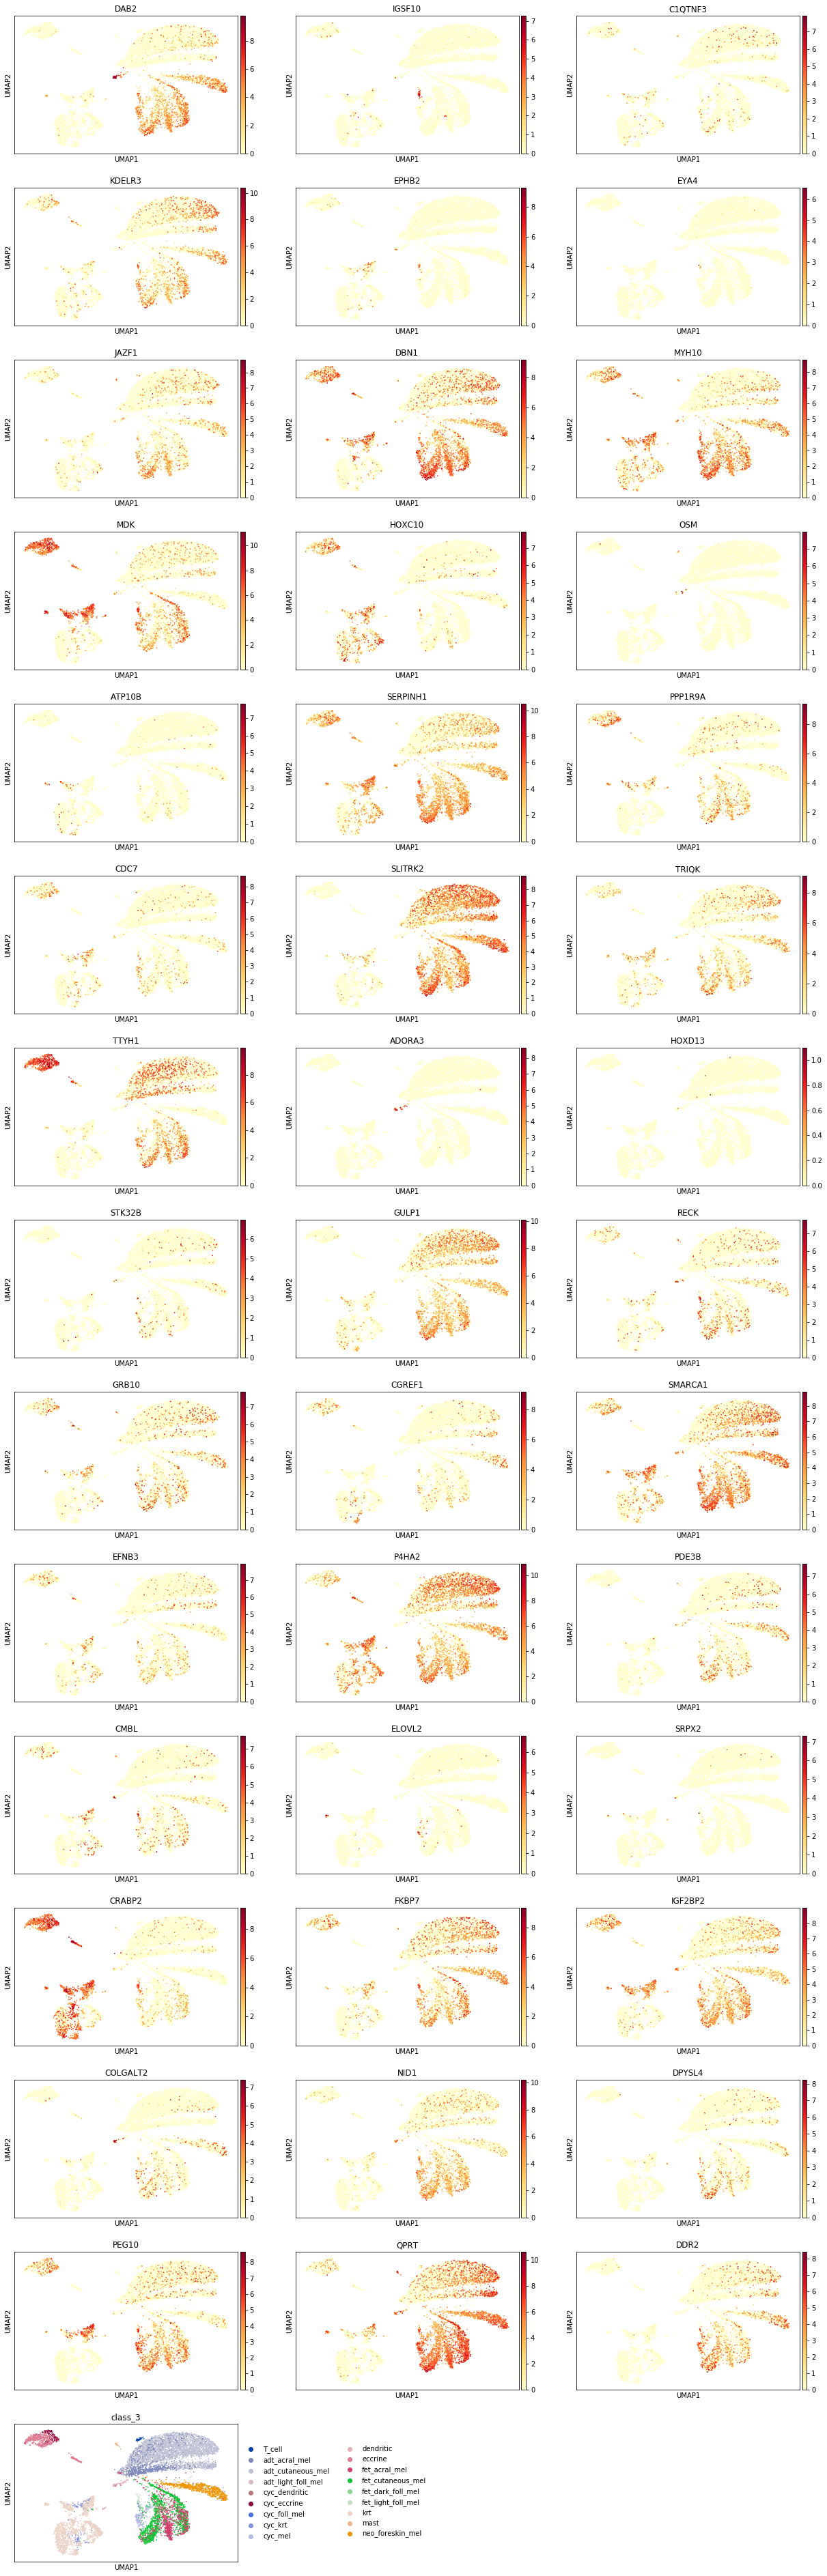

In [18]:
print('...')
# mouse data
# source = https://www.biorxiv.org/content/10.1101/721712v1
# converter = https://www.syngoportal.org/convert.html
mouse_sym = pd.read_csv('s3://daniel.le-work/MEL_project/DL20191003_mouse2house.csv')
mouse_sym = mouse_sym['query'].tolist()
mouse_sym = list(set(mouse_sym) & set(full_adata.var_names))
sc.pl.umap(full_adata, color=mouse_sym+['class_3'], cmap='YlOrRd', ncols=3)

...


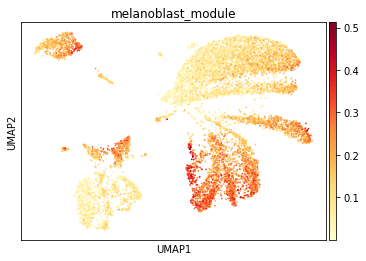

In [19]:
print('...')
input_adata = full_adata
cat, exp_df = prepare_dataframe(input_adata,
                     var_names = input_adata.var_names,
                     groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranked expression per cell
input_adata.obs['melanoblast_module'] = exp_df.loc[:,mouse_sym].mean(axis=1)

sc.pl.umap(input_adata, color='melanoblast_module', cmap='YlOrRd')